# Gaussian Processes

In this script, we are investigating the main idea behind using Gaussian Processes and how conditional probability can be used to make predictions from data.
The idea is that we have a function that it is unknown to the use (originator function below). We sample the function in different "experiments" and we get noisy data in return.
We will use such data to construct a Gaussian Process.  

## Creation of the Originator function

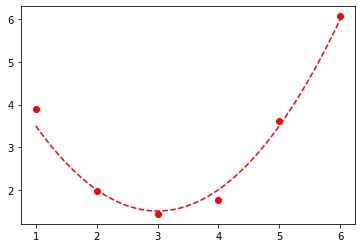

In [17]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(1,6,num=6)
beta0 = 6
beta1 = -3
beta2 = 0.5
sigma = 0.2
def funct(x,beta0,beta1,beta2,sigma):
    return np.array((np.ones(len(x)),x,x**2)).T.dot(np.array([beta0,beta1,beta2]).T)+sigma*np.random.randn(len(x),1).T

f = funct(x,beta0,beta1,beta2,sigma)
plt.plot(x,np.reshape(f, (-1,1)),"or")
plt.plot(np.linspace(1,6,num=100),np.reshape(funct(np.linspace(1,6,num=100),beta0,beta1,beta2,0), (-1,1)),"--r")

## Data generation

Define the number of experiments, i.e. how many times the underlying process is sampled at the different values of x.

In [18]:
num_exp = 25

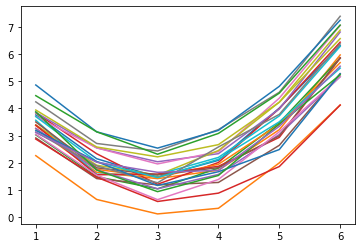

In [20]:
x = np.linspace(1,6,num=6)
beta0 = 6
beta1 = -3
beta2 = 0.5
sigma = 0.2

y = np.zeros((num_exp,len(x)))
for n in range(num_exp):
    y[n] = funct(x,beta0+0.5*np.random.randn(1)[0],beta1+0.1*np.random.randn(1)[0],beta2+0.01*np.random.randn(1)[0],sigma)
    plt.plot(x,y[n])

## Plot correlations

Here, we show as an example how the data at x=1 are correlated to those at x=2.
Below, we compute the mean of the function at each sampling point and the corresponding coviance/correlation matrices.

Text(0, 0.5, 'y(x=2)')

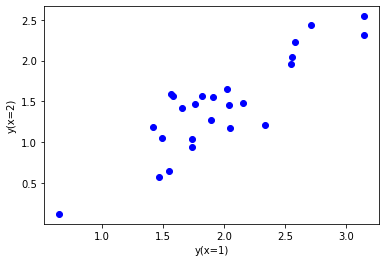

In [21]:
plt.plot(y[:,1],y[:,2],"ob")
plt.xlabel("y(x=1)")
plt.ylabel("y(x=2)")

In [71]:
Y_mu = np.mean(y, axis=0)
pd.DataFrame(Y_mu)

,0
0,3.503818
1,1.981509
2,1.460370
3,1.998974
4,3.512228
5,5.960900


In [70]:
Y_cov = np.cov(y, rowvar= False)
pd.DataFrame(Y_cov)

,0,1,2,3,4,5
0,0.303358,0.283925,0.270527,0.318406,0.357214,0.380640
1,0.283925,0.325440,0.291897,0.338921,0.367393,0.409175
2,0.270527,0.291897,0.341507,0.361809,0.372933,0.453743
3,0.318406,0.338921,0.361809,0.461897,0.486186,0.560940
4,0.357214,0.367393,0.372933,0.486186,0.602525,0.642799
5,0.380640,0.409175,0.453743,0.560940,0.642799,0.774774


In [24]:
Y_corr = np.corrcoef(y, rowvar= False)
Y_corr

array([[1.        , 0.90363011, 0.84049088, 0.8506102 , 0.83553138,
        0.78514447],
       [0.90363011, 1.        , 0.87557608, 0.87415974, 0.82967418,
        0.81486675],
       [0.84049088, 0.87557608, 1.        , 0.91097705, 0.82213555,
        0.88211131],
       [0.8506102 , 0.87415974, 0.91097705, 1.        , 0.92160022,
        0.93768349],
       [0.83553138, 0.82967418, 0.82213555, 0.92160022, 1.        ,
        0.94080634],
       [0.78514447, 0.81486675, 0.88211131, 0.93768349, 0.94080634,
        1.        ]])

## Use Corralations

If we define the correlation structure and suppose that the underlying probability density function is a multivariate normal distribution, we can sample from such distribution and generate new data.
Then we can plot all the pairs of data at x=1 and x=2 from such distribution.

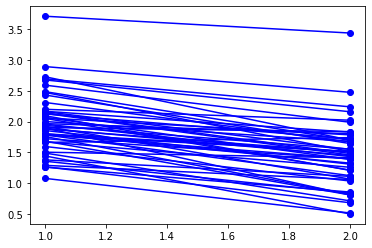

In [72]:
from matplotlib.widgets import Slider, Button

Y = np.random.multivariate_normal(Y_mu,Y_cov,100000)

amm_samples = 50

for n in range(amm_samples):
     plt.plot([1,2],[Y[n,1],Y[n,2]],'b-o')


## Compute conditional probability

What is the distribution of f(x) at x=2 assuming that f(x=1) = 3?
This is a typical conditional probability problem, where we have to "conditionally" sample from the original distribution.

Text(0, 0.5, 'Probability density')

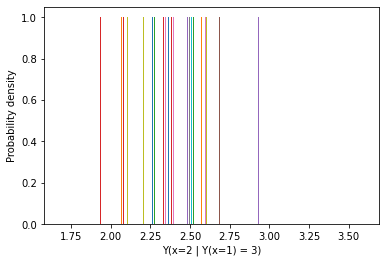

In [42]:
rows = np.where((Y[:,1] > 2.99) & (Y[:,1] < 3.01))
plt.hist(Y[rows,2])

# TODO: fix the graph

plt.xlabel('Y(x=2 | Y(x=1) = 3)')
plt.ylabel('Probability density')

# Propagation Models

man models are "back-box" models, i.e. they were directly connecting manipulated variables (inputs) to final titer (output). Except for the historical models (which require the knowledge of the process evolution), such models do not consider process data.
Here, we explore a straightforward way of integrating all process data into a Gaussian Process models, in the so called propagation models. Here, what is being predicted is not the values per se but rather the 1st derivative of the timeseries. And so, the In a first step, a model for the X variables at day 1 is created using the 1st derivatives of the timeseries in each run. To explain further, on training, we take the data in an OWu matrix format and obtain the consecutive time differences. These will be used to fit the model. Then, on the prediction, we look at the initial conditions of the input data and from there, the data is propagated so we can obtain the desired  amount of days


## Train the models

In [62]:
import pandas as pd
import numpy as np
import copy
from typing import Union
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler

# GP model training function
def train_propagation_model(owu_input, num_runs):

    # set conditions
    Nvar = 5
    Ndays = 14

    owu_input = owu_csv_to_multiindex(owu_input, Ndays, num_runs)
    owu_input = owu_input.loc[:10]

    owu_shortened = pd.DataFrame()
    owu_diff = pd.DataFrame()

    # Get the time differences (assumed to be 1 day
    for _, run in owu_input.groupby(level="run"):
        diff = run.diff(axis=0)
        diff = diff[1:]  # remove the nan on index 0
        run_shortened = run.iloc[:-1].copy()
        owu_diff = pd.concat([owu_diff, diff])
        owu_shortened = pd.concat([owu_shortened, run_shortened])

    owu_diff.index = owu_diff.index.get_level_values("run")
    owu_shortened.index = owu_shortened.index.get_level_values(
        "run"
    )  # Becasue getting the time intervals removes one timestamp

    # Scale the input and get the result in a pd.DataFrame
    scaler = StandardScaler()
    owu_shortened_scaled = pd.DataFrame(
        scaler.fit_transform(owu_shortened),
        index=owu_shortened.index,
        columns=owu_shortened.columns,
    )
    trained_models = [[None] * Ndays] * Nvar
    # trained_models = [None] * Nvar

    for day in range(Ndays):
        for nvar in range(Nvar):
            kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
            gaussian_process = GaussianProcessRegressor(
                kernel=kernel,
                normalize_y=True,
                random_state=10,
            )
            var_name = [owu_diff.columns[nvar]]
            trained_models[nvar][day] = gaussian_process.fit(
                owu_shortened_scaled[var_name], owu_diff[owu_diff.columns[nvar]]
            )
    return trained_models

def predict_propagation_model(
    input_owu: Union[pd.DataFrame, np.ndarray], trained_models: list
) -> pd.DataFrame:

    # set conditions
    Nvar = 4
    Ndays = 14

    # train models

    owu = owu_csv_to_multiindex(input_owu, Ndays, num_runs)
    scaler = StandardScaler()
    owu_shortened_scaled = pd.DataFrame(
        scaler.fit_transform(owu),
        index=owu.index,
        columns=owu.columns,
    )
    y_pred = copy.copy(owu_shortened_scaled)
    for day in range(Ndays):
        for var_ix, _ in enumerate(owu_shortened_scaled.columns):
            var_name = y_pred.columns[var_ix]
            datapoint = owu[var_name].loc[day].values.reshape(-1, 1)

            y_pred[var_name].loc[day] = (
                trained_models[var_ix][day]
                .predict(datapoint, return_std=False)
                .reshape(-1)
            )

    # Use the gradients and the starting conditions to get the final values
    for run_ix in range(num_runs):
        for col in owu.columns:
            y_pred[col].loc[run_ix].iloc[0] = (
                owu[col].loc[run_ix].iloc[0] + y_pred[col].loc[run_ix].iloc[0]
            )
    y_pred = y_pred.groupby(level="run").cumsum()

    return y_pred

def owu_from_csv(csv_path: str) -> pd.MultiIndex:
    """
    Generates an observation-wise unfolded matrix from the csv file obtained from 'generate_data'
    Parameters
    ----------
    csv_path : str
        path to the .csv file containing the generated data
    Returns
    --------
    owu : pd.MultiIndex
        Observation-wise unfolded matrix that resulted from the.csv data
    """
    pd.options.mode.chained_assignment = None  # default='warn'
    # Import the generated data into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Identify the indexes where the runs start and create a column for runs
    run_start_ix = df[df["timestamps"] == 0].index
    n_runs = len(run_start_ix)
    df["run"] = -1

    # Place the correct indexes in the "runs" columns
    for run in range(n_runs - 2):
        df["run"].loc[run_start_ix[run] : run_start_ix[run + 1]] = run

    # Place the run number on the last indexes
    df["run"].loc[run_start_ix[n_runs - 1] :] = n_runs - 1

    # Turn the timestamps and the runs into multiindexes
    indexes = pd.MultiIndex.from_frame(df[["run", "timestamps"]])
    df = df.drop(columns=["run", "timestamps"])
    owu = pd.DataFrame(df.values, columns=df.columns, index=indexes)

    return owu

In [74]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

owu = pd.read_csv("datasets\owu.csv")
num_runs = 100
trained_models = train_propagation_model(owu, num_runs)

owu_import = pd.read_csv("datasets\owu.csv")
num_runs = 100
trained_models = train_propagation_model(owu_import, num_runs)
y_pred = predict_propagation_model(owu_import, trained_models)
Nvar = 5
Ndays = 14

owu_test = owu_csv_to_multiindex(owu_import, Ndays, num_runs)



### Prediction: test the models on Test Set

Here, the testing RMSE of the 1st run is shown on the Glucose variable

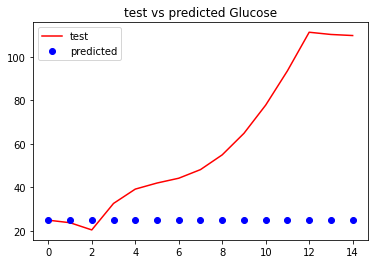

47.13159988514428

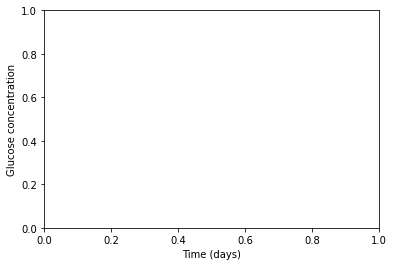

In [76]:
#GLN plot
plt.plot(owu_test.loc[0].index, owu_test[" X:Glc"].loc[0], "-r", label="test")
plt.plot(owu_test.loc[0].index, y_pred[" X:Glc"].loc[0], "ob", label="predicted")
plt.legend()
plt.title("test vs predicted Glucose")
plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Glucose concentration")


#test set rmse bar plot

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(y_pred[" X:Glc"].loc[0], owu_test[" X:Glc"].loc[0])